In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.0
GPU is available


In [2]:
# %% === < Global Setting: Time and Seed > ===
import time
import numpy as np
local_time = time.strftime("%Y%m%d_%H%M", time.localtime())
print("Time:", local_time)
seed = int(round(1000000*np.random.random()))
print("Seed:", seed)
np.random.seed(seed)

Time: 20210608_1749
Seed: 183166


In [3]:
import os
output_folder = './Result/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

(512, 512, 3)
(512, 512)


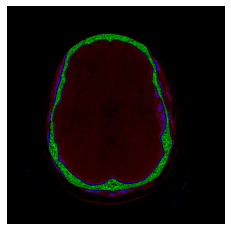

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('./Data/TrainDataWindow2R/epidural/ID_000edbf38.png')
img_shape = img.shape
img_size = img_shape[0:2]
print(img_shape)
print(img_size)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
# %% === < Images importing > ===
import os
import tensorflow as tf
batch_size = 16
print('raw image size:',img_size)
print('raw image shape:',img_shape)

TrainDataFolder = 'Data/TrainDataWindow2R'
ValidDataFolder = 'Data/ValidDataWindow2R'
TestDataFolder = 'Data/TestDataWindow2R'
TrainDataGenerator = 'Data/TrainDataGenerator'
ValidDataGenerator = 'Data/ValidDataGenerator'
if not os.path.exists(TrainDataGenerator):
    os.makedirs(TrainDataGenerator)
if not os.path.exists(ValidDataGenerator):
    os.makedirs(ValidDataGenerator)

raw image size: (512, 512)
raw image shape: (512, 512, 3)


In [6]:
model_img_side = 224
image_size = (model_img_side,model_img_side)
image_shape = (model_img_side,model_img_side,3)
print('image size:',image_size)
print('image shape:',image_shape)

image size: (224, 224)
image shape: (224, 224, 3)


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_kwargs = dict(rescale=1./255)

TrainDataGenerator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    **datagen_kwargs
    )
ValidDataGenerator = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=[0.9,1.1],
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     fill_mode='nearest',
    **datagen_kwargs
    )
TestDataGenerator = ImageDataGenerator(
    **datagen_kwargs
    )

In [29]:
dataflow_kwargs = dict(target_size=image_size, batch_size=batch_size)

TrainingDataset = TrainDataGenerator.flow_from_directory(
    TrainDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )
ValidationDataset = ValidDataGenerator.flow_from_directory(
    ValidDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )
TestingDataset = TestDataGenerator.flow_from_directory(
    TestDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )

Found 4200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [9]:
print('Number of category: %d' % TrainingDataset.num_classes)

Number of category: 6


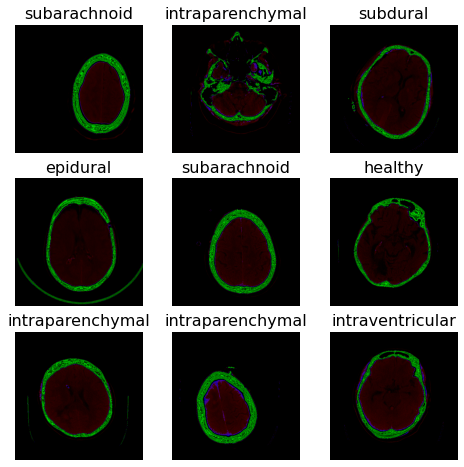

In [61]:
import matplotlib.pyplot as plt
import cv2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

files_path = TrainingDataset.filenames
demo_files_path = np.random.choice(files_path,9)

plt.figure(figsize=(8,8))
idx = 0
for file in demo_files_path:
    ax = plt.subplot(3, 3, idx + 1)
    img = cv2.imread(os.path.join(TrainDataFolder,file))
    category_name = os.path.split(file)
    plt.imshow(img)
    plt.title(category_name[0])
    plt.axis("off")
    idx = idx + 1
plt.savefig(output_folder+'Example_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [11]:
# # %% === < Importing pretrained model with custom input shape > ===
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# model_pretrained = ResNet50(weights='imagenet', include_top=True)
# model_pretrained.summary()

In [12]:
# %% === < Importing pretrained model with custom input shape > ===
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
model_pretrained = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
model_pretrained.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
model_pretrained.trainable = False

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential([
    model_pretrained,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(TrainingDataset.num_classes, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 75,101,318
Trainable params: 51,513,606
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
model.compile(
    optimizer = Adam(learning_rate = 0.001), 
    loss = CategoricalCrossentropy(), 
    metrics = ['accuracy']
    )
initial_epochs = 10
loss0, accuracy0 = model.evaluate(ValidationDataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

113/113 [==============================] - 21s 161ms/step - loss: 2.4591 - accuracy: 0.0921
Initial loss: 2.20
Initial accuracy: 0.17


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
steps_per_epoch = TrainingDataset.samples // TrainingDataset.batch_size
validation_steps = ValidationDataset.samples // ValidationDataset.batch_size
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    patience = 5,
    verbose = 1
    )
LRSchedule = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3, 
    verbose = 1
    )
history = model.fit(
    TrainingDataset,
    validation_data = ValidationDataset,
    epochs = initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose = 1,
    callbacks = [EarlyStop, LRSchedule]
    )

Epoch 1/10
262/262 [==============================] - 63s 234ms/step - loss: 5.0478 - accuracy: 0.1718 - val_loss: 1.7921 - val_accuracy: 0.1629
Epoch 2/10
262/262 [==============================] - 61s 233ms/step - loss: 1.8049 - accuracy: 0.1750 - val_loss: 1.7921 - val_accuracy: 0.1629
Epoch 3/10
262/262 [==============================] - 61s 232ms/step - loss: 1.7942 - accuracy: 0.1539 - val_loss: 1.7921 - val_accuracy: 0.1629
Epoch 4/10
262/262 [==============================] - 61s 232ms/step - loss: 1.7938 - accuracy: 0.1329 - val_loss: 1.7919 - val_accuracy: 0.1629
Epoch 5/10
262/262 [==============================] - 61s 232ms/step - loss: 1.7936 - accuracy: 0.1635 - val_loss: 1.7919 - val_accuracy: 0.1629
Epoch 6/10
262/262 [==============================] - 61s 232ms/step - loss: 1.7930 - accuracy: 0.1224 - val_loss: 1.7919 - val_accuracy: 0.1629
Epoch 7/10
262/262 [==============================] - 61s 232ms/step - loss: 1.7932 - accuracy: 0.1185 - val_loss: 1.7918 - val_ac

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

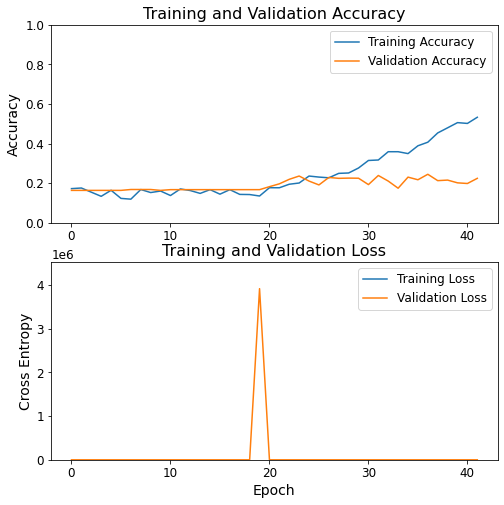

In [60]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.1*max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig(output_folder+'History_BeforeTune_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [19]:
model_pretrained.trainable = True

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
model.compile(
    optimizer = Adam(learning_rate = 0.001), 
    loss = CategoricalCrossentropy(), 
    metrics = ['accuracy']
    )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 75,101,318
Trainable params: 75,048,198
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
fine_tune_1_epochs = 190
total_1_epochs =  initial_epochs + fine_tune_1_epochs
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    patience = 15,
    verbose = 1
    )
LRSchedule = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 10, 
    verbose = 1
    )
history_fine_1 = model.fit(TrainingDataset,
    validation_data=ValidationDataset,
    epochs=total_1_epochs,
    initial_epoch=history.epoch[-1],
    verbose = 1,
    callbacks = [EarlyStop, LRSchedule]
    )

Epoch 10/200
263/263 [==============================] - 67s 240ms/step - loss: 5.5586 - accuracy: 0.1436 - val_loss: 2.3664 - val_accuracy: 0.1667
Epoch 11/200
263/263 [==============================] - 61s 232ms/step - loss: 1.9414 - accuracy: 0.1489 - val_loss: 54.5421 - val_accuracy: 0.1667
Epoch 12/200
263/263 [==============================] - 61s 232ms/step - loss: 1.8100 - accuracy: 0.1736 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 13/200
263/263 [==============================] - 61s 232ms/step - loss: 1.7916 - accuracy: 0.1949 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 14/200
263/263 [==============================] - 61s 233ms/step - loss: 1.7920 - accuracy: 0.1749 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 15/200
263/263 [==============================] - 61s 232ms/step - loss: 1.7921 - accuracy: 0.1614 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 16/200
263/263 [==============================] - 61s 233ms/step - loss: 1.7918 - accuracy: 0.2093 - val_loss: 

In [23]:
acc += history_fine_1.history['accuracy']
val_acc += history_fine_1.history['val_accuracy']

loss += history_fine_1.history['loss']
val_loss += history_fine_1.history['val_loss']

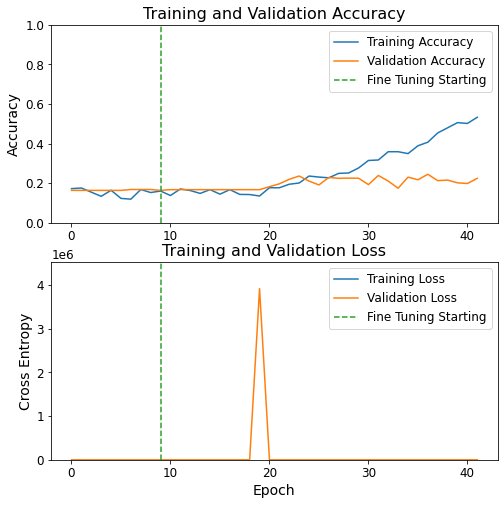

In [59]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim([0,1]),'--', label='Fine Tuning Starting')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim([0,1.1*max(plt.ylim())]),'--', label='Fine Tuning Starting')
plt.ylim([0,max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig(output_folder+'History_FineTuning_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [25]:
# --- saving weights and structure
model_h5_folder = output_folder+'ModelWeights/'
model_h5_file = 'ResNet50_' + local_time + '.h5'
model.save(model_h5_folder + model_h5_file)  # creates a HDF5 file

<Figure size 432x288 with 0 Axes>

In [30]:
list_loss = []
list_acc = []

loss, accuracy = model.evaluate(TrainingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Training loss: {:.4f}".format(loss))
print("Training accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(ValidationDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Validation loss: {:.4f}".format(loss))
print("Validation accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(TestingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Testing loss: {:.4f}".format(loss))
print("Testing accuracy: {:.4f}".format(accuracy))

with open(output_folder+'loss_%s.txt'%local_time, 'w') as f:
    for item in list_loss:
        f.write("%s\n" % item)
with open(output_folder+'acc_%s.txt'%local_time, 'w') as f:
    for item in list_acc:
        f.write("%s\n" % item)

263/263 [==============================] - 42s 161ms/step - loss: 2.1821 - accuracy: 0.2110
Training loss: 2.1821
Training accuracy: 0.2110
113/113 [==============================] - 18s 160ms/step - loss: 2.1582 - accuracy: 0.2072
Validation loss: 2.1582
Validation accuracy: 0.2072
38/38 [==============================] - 4s 98ms/step - loss: 2.2849 - accuracy: 0.2050
Testing loss: 2.2849
Testing accuracy: 0.2050


In [32]:
pred_prop_training = model.predict(TrainingDataset)
pred_prop_validation = model.predict(ValidationDataset)
pred_prop_testing = model.predict(TestingDataset)
print(pred_prop_testing)

pred_training = tf.argmax(pred_prop_training, axis=1)
pred_validation = tf.argmax(pred_prop_validation, axis=1)
pred_testing = tf.argmax(pred_prop_testing, axis=1)
print(pred_testing)

true_training = TrainingDataset.classes
true_validation = ValidationDataset.classes
true_testing = TestingDataset.classes
print(true_testing)

[[2.2148496e-01 2.0111869e-03 9.4889045e-02 3.2146382e-03 3.0504271e-01
  3.7335742e-01]
 [2.9907954e-01 2.9752299e-04 2.0811607e-01 2.2764493e-02 9.1945097e-02
  3.7779734e-01]
 [3.0987531e-01 1.3424229e-03 1.6639414e-01 4.2401981e-02 1.4803028e-01
  3.3195579e-01]
 ...
 [2.6346079e-01 3.1924501e-04 1.4323626e-01 6.8818340e-03 1.2403400e-01
  4.6206790e-01]
 [2.6413718e-01 4.2843251e-04 1.2070671e-01 6.0258294e-03 1.5289128e-01
  4.5581055e-01]
 [2.6201558e-01 1.9219816e-04 1.6964898e-01 3.5010630e-03 1.3540468e-01
  4.2923754e-01]]
tf.Tensor(
[5 5 5 4 0 4 0 5 5 5 5 0 5 5 5 5 4 5 5 5 4 5 5 5 4 5 0 0 5 5 5 4 0 0 5 5 5
 4 0 5 5 5 5 0 4 5 5 5 5 4 5 5 4 5 5 5 5 5 0 5 0 5 0 4 4 0 2 5 5 5 5 5 5 5
 5 5 5 0 5 4 5 5 5 5 5 4 5 5 5 0 4 5 0 3 5 0 5 5 4 5 5 4 4 4 0 5 4 4 0 5 0
 1 0 5 4 5 5 0 1 4 0 5 0 4 3 0 5 4 0 4 5 1 1 0 5 5 4 1 0 4 4 0 4 2 4 5 5 5
 5 5 4 1 5 0 4 4 4 4 5 0 1 5 4 5 5 5 5 1 1 5 4 0 5 4 5 0 5 5 5 5 5 4 5 4 5
 0 4 4 5 5 5 5 4 2 1 4 5 4 0 4 5 4 5 5 2 5 4 0 4 5 5 5 5 5 5 5 5 5 4 4 5 5

In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def info(true,pred,type_data):
    # === Accuracy
    print("Accuracy: %.4f"%accuracy_score(true,pred))
    report = classification_report(true,pred,output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(output_folder+'ClassificationReport_%s_%s.csv'%(type_data,local_time), index = True)
    print(classification_report(true,pred))
    # === Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix(true,pred,normalize=None), annot=True, cmap='YlGnBu')
#     xticklabels=target_names, yticklabels=target_names
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.savefig(output_folder+'ConfusionMatrix_%s_%s.png'%(type_data,local_time), dpi=300, bbox_inches='tight')
    plt.show()
    # === Normalized Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix(true,pred,normalize='true'), annot=True, cmap='Blues', vmin=0, vmax=1)
#     xticklabel=starget_names, yticklabels=target_names
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.savefig(output_folder+'NormalizeConfusionMatrix_%s_%s.png'%(type_data,local_time), dpi=300, bbox_inches='tight')
    plt.show() 

Accuracy: 0.1974
              precision    recall  f1-score   support

           0       0.16      0.16      0.16       700
           1       1.00      0.11      0.19       700
           2       0.16      0.03      0.05       700
           3       0.36      0.10      0.16       700
           4       0.15      0.23      0.18       700
           5       0.20      0.56      0.29       700

    accuracy                           0.20      4200
   macro avg       0.34      0.20      0.17      4200
weighted avg       0.34      0.20      0.17      4200



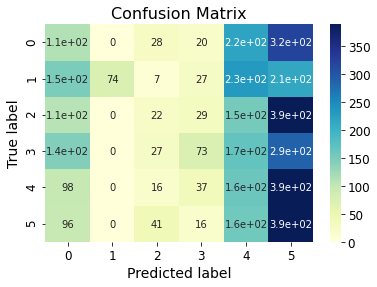

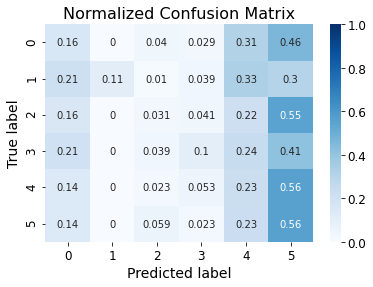

In [63]:
info(true_training,pred_training,'training')

Accuracy: 0.2189
              precision    recall  f1-score   support

           0       0.19      0.20      0.19       300
           1       0.97      0.12      0.21       300
           2       0.19      0.04      0.06       300
           3       0.34      0.11      0.17       300
           4       0.17      0.25      0.20       300
           5       0.21      0.59      0.31       300

    accuracy                           0.22      1800
   macro avg       0.35      0.22      0.19      1800
weighted avg       0.35      0.22      0.19      1800



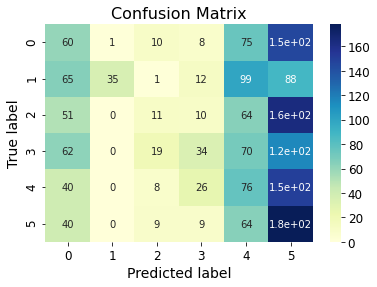

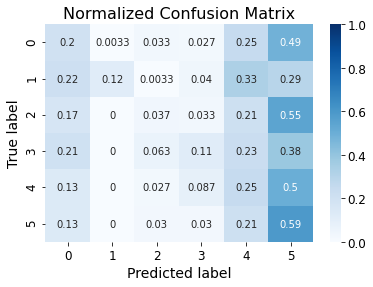

In [64]:
info(true_validation,pred_validation,'validation')

Accuracy: 0.2050
              precision    recall  f1-score   support

           0       0.19      0.17      0.18       100
           1       1.00      0.10      0.18       100
           2       0.17      0.01      0.02       100
           3       0.36      0.04      0.07       100
           4       0.13      0.16      0.14       100
           5       0.21      0.75      0.33       100

    accuracy                           0.20       600
   macro avg       0.34      0.20      0.15       600
weighted avg       0.34      0.20      0.15       600



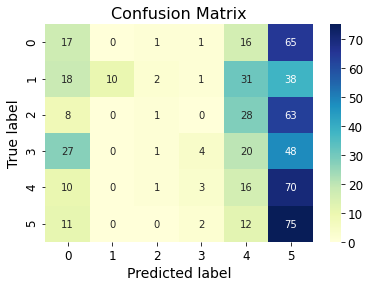

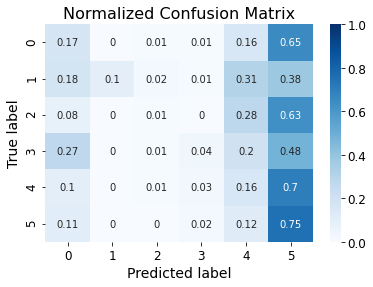

In [65]:
info(true_testing,pred_testing,'testing')

In [66]:
# %% === < Finish Time > ===
import time
print("Finish Time:", time.strftime("%Y%m%d_%H%M", time.localtime()))

Finish Time: 20210608_2048
